In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split as holdout
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics
import numpy as np

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Web Scraping using BeautifulSoup

In [2]:
header = {
    "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.88 Safari/537.36",
    "Accept-Language": "en-US,en;q=0.9"
}

In [3]:
links=[]
para=['1_p','2_p', '3_p', '4_p', '5_p', '6_p','7_p']
url='https://www.zillow.com/beverly-hills-ca-90210/{}/'
for p in para:
  new_link=url.format(p)
  links.append(new_link)
print(links[3])

https://www.zillow.com/beverly-hills-ca-90210/4_p/


In [4]:
price = []
house_info = []
address = []
for url in links:
  response = requests.get(url, headers=header)
  data = response.text
  

  soup = BeautifulSoup(data, 'html.parser')
  amount = list(soup.find_all('div', class_='list-card-price'))
  for i in amount:
      price.append(i.text)

  #response = requests.get(i, headers=header)
  #data = response.text
  #soup = BeautifulSoup(data, 'html.parser')
  beds = list(soup.find_all('ul',class_='list-card-details'))
  for i in beds:
      house_info.append(i.text)

  #response = requests.get(i, headers=header)
  #data = response.text
  #soup = BeautifulSoup(data, 'html.parser')
  x = list(soup.find_all('address',class_='list-card-addr'))
  for i in x:
      address.append(i.text)


In [5]:
house_data = []
house_data.append(price)
house_data.append(house_info)
house_data.append(address)
dict = {'price':house_data[0], 'house_info':house_data[1], 'address':house_data[2]}
data = pd.DataFrame(dict)
print(data.shape)

(252, 3)


In [6]:
df = data.copy()

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   price       252 non-null    object
 1   house_info  252 non-null    object
 2   address     252 non-null    object
dtypes: object(3)
memory usage: 6.0+ KB


# Cleaning Data

In [8]:
df['prices'] = df['price'].apply(lambda x: x[1:])

In [9]:
df[['beds','baths','sq_feet','sqft_unit','type','for','sale','None']] = df['house_info'].str.split(expand=True)

In [10]:
df.head(1)

,price,house_info,address,prices,beds,baths,sq_feet,sqft_unit,type,for,sale,None
0,"$46,500,000","6 bds,9 ba,21,046 sqft- House for sale","1426 Summitridge Dr, Beverly Hills, CA 90210","46,500,000",6,"bds,9","ba,21,046",sqft-,House,for,sale,None


In [11]:
df[['redundant','baths']] = df['baths'].str.split(',',n=1,expand=True)

In [12]:
df['sq_feet']=df['sq_feet'].replace('ba,','',regex=True)

In [13]:
df[['street_name','city','state_zip_code']]=df['address'].str.split(',',n=2, expand=True)

In [14]:
df.head(1)

,price,house_info,address,prices,beds,baths,sq_feet,sqft_unit,type,for,sale,None,redundant,street_name,city,state_zip_code
0,"$46,500,000","6 bds,9 ba,21,046 sqft- House for sale","1426 Summitridge Dr, Beverly Hills, CA 90210","46,500,000",6,9,"21,046",sqft-,House,for,sale,None,bds,1426 Summitridge Dr,Beverly Hills,CA 90210


In [15]:
#drop unnecessary columns
feature_drop = ['price','house_info','for', 'sale','redundant','sqft_unit','None']
df1 = df.drop(feature_drop, axis=1)

In [16]:
df1.head()

,address,prices,beds,baths,sq_feet,type,street_name,city,state_zip_code
0,"1426 Summitridge Dr, Beverly Hills, CA 90210","46,500,000",6,9,"21,046",House,1426 Summitridge Dr,Beverly Hills,CA 90210
1,"2571 Wallingford Dr, Beverly Hills, CA 90210","85,000,000",12,24,"38,000",House,2571 Wallingford Dr,Beverly Hills,CA 90210
2,"67 Beverly Park Ct, Beverly Hills, CA 90210","160,000,000",13,25,"28,660",House,67 Beverly Park Ct,Beverly Hills,CA 90210
3,"1130 Carolyn Way, Beverly Hills, CA 90210","24,500,000",6,13,"12,127",House,1130 Carolyn Way,Beverly Hills,CA 90210
4,"9833 Easton Dr, Beverly Hills, CA 90210","1,495,000",3,3,"1,500",House,9833 Easton Dr,Beverly Hills,CA 90210


In [17]:
#beakup state_zip_code into state and zip code
df1['zip_code'] = df1['state_zip_code'].replace('CA ','', regex=True)

In [18]:
#reorder columns
zillow_df = df1[['prices','beds','baths','sq_feet','type','address','street_name',
       'city', 'zip_code']]

In [19]:
#pd.to_numeric(zillow_df['baths'])
zillow_df['prices'] = zillow_df['prices'].str.replace(',','').astype(float)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [21]:
zillow_df['beds']=zillow_df['beds'].replace('Studio,--', None)
zillow_df['beds']=zillow_df['beds'].replace('--', None)
zillow_df['beds']=zillow_df['beds'].str.replace(',', '').astype(float)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

In [23]:
zillow_df['baths'] = zillow_df['baths'].replace('--', None)
zillow_df['baths'] = zillow_df['baths'].str.replace(',','').astype(float)


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [25]:

zillow_df['sq_feet'] = zillow_df['sq_feet'].replace('--', None)
zillow_df['sq_feet'] = zillow_df['sq_feet'].replace('lot-', None)
zillow_df['sq_feet'] = zillow_df['sq_feet'].replace('sqft-', None)
zillow_df['sq_feet'] = zillow_df['sq_feet'].str.replace(',','').astype(float)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

# Final Dataset - zillow_df
Now we are going to do Data Visualization and Model Development using the zillow_df dataset.

In [26]:
zillow_df.head()

,prices,beds,baths,sq_feet,type,address,street_name,city,zip_code
0,46500000.0,6.0,9.0,21046.0,House,"1426 Summitridge Dr, Beverly Hills, CA 90210",1426 Summitridge Dr,Beverly Hills,90210
1,85000000.0,12.0,24.0,38000.0,House,"2571 Wallingford Dr, Beverly Hills, CA 90210",2571 Wallingford Dr,Beverly Hills,90210
2,160000000.0,13.0,25.0,28660.0,House,"67 Beverly Park Ct, Beverly Hills, CA 90210",67 Beverly Park Ct,Beverly Hills,90210
3,24500000.0,6.0,13.0,12127.0,House,"1130 Carolyn Way, Beverly Hills, CA 90210",1130 Carolyn Way,Beverly Hills,90210
4,1495000.0,3.0,3.0,1500.0,House,"9833 Easton Dr, Beverly Hills, CA 90210",9833 Easton Dr,Beverly Hills,90210


In [27]:
zillow_df.shape

(252, 9)

In [28]:
zillow_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   prices       252 non-null    float64
 1   beds         252 non-null    float64
 2   baths        232 non-null    float64
 3   sq_feet      252 non-null    float64
 4   type         252 non-null    object 
 5   address      252 non-null    object 
 6   street_name  252 non-null    object 
 7   city         252 non-null    object 
 8   zip_code     252 non-null    object 
dtypes: float64(4), object(5)
memory usage: 17.8+ KB


In [29]:
zillow_df.describe()

,prices,beds,baths,sq_feet
count,2.520000e+02,252.000000,232.000000,252.000000
mean,1.316889e+07,35.832183,79.788793,6284.019841
std,1.905970e+07,480.028734,1115.681421,4846.215277
min,3.990000e+05,0.280000,2.000000,1016.000000
25%,3.498000e+06,3.000000,4.000000,2984.500000
50%,6.900000e+06,5.000000,6.000000,5098.500000
75%,1.606250e+07,6.000000,8.000000,8015.000000
max,1.600000e+08,7624.000000,17000.000000,38000.000000


## Data Visualization and EDA

Text(0, 0.5, 'Number of Bathrooms')

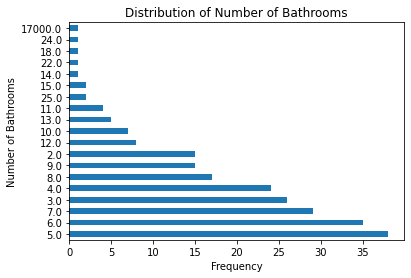

In [30]:
zillow_df['baths'].value_counts().plot.barh()
plt.title('Distribution of Number of Bathrooms')
plt.xlabel('Frequency')
plt.ylabel('Number of Bathrooms')

Text(0, 0.5, 'Type of Property')

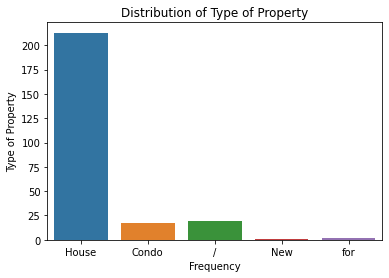

In [31]:
sns.countplot(zillow_df['type'])
plt.title('Distribution of Type of Property')
plt.xlabel('Frequency')
plt.ylabel('Type of Property')

Text(0.5, 0, 'Prices (10 Millions)')

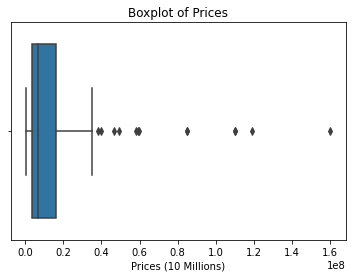

In [32]:
sns.boxplot(zillow_df['prices'])
plt.title('Boxplot of Prices')
plt.xlabel('Prices (10 Millions)')


Text(0.5, 0, 'Squre Feet')

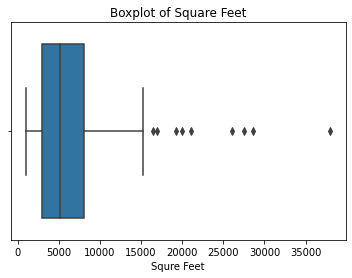

In [33]:
sns.boxplot(zillow_df['sq_feet'])
plt.title('Boxplot of Square Feet')
plt.xlabel('Squre Feet')

Text(0.5, 0, 'beds')

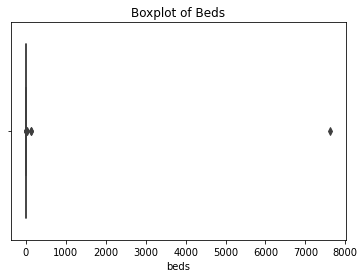

In [34]:
sns.boxplot(zillow_df['beds'])
plt.title('Boxplot of Beds')
plt.xlabel('beds')

Text(0, 0.5, 'count frequency')

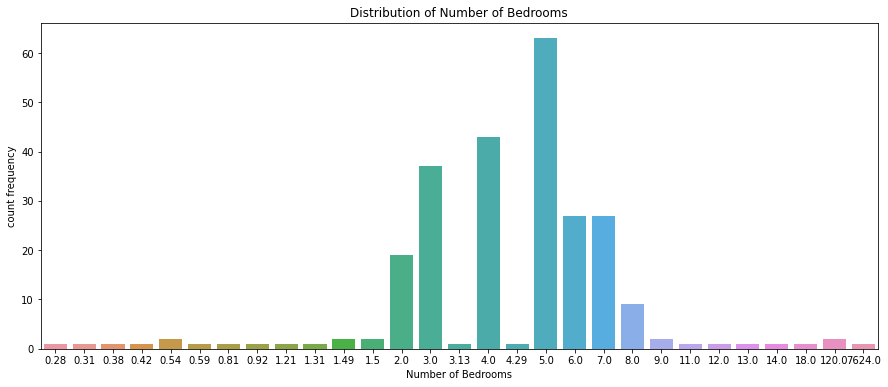

In [35]:
plt.figure(figsize=(15,6))
sns.countplot(zillow_df['beds'])
plt.title('Distribution of Number of Bedrooms')
plt.xlabel('Number of Bedrooms')
plt.ylabel('count frequency')

In [36]:
df=zillow_df.groupby(['type'])['beds'].mean().to_frame().rename(columns={'id':'count'}).reset_index()

In [37]:
df = df[df['type'] != '/']

Text(0.5, 1.0, 'Distribution of Type of Houses in Average')

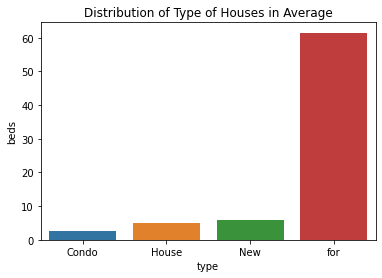

In [38]:
sns.barplot('type','beds',data=df)
plt.title('Distribution of Type of Houses in Average')


In [39]:
zillow_df = zillow_df[zillow_df['beds'] < 100]

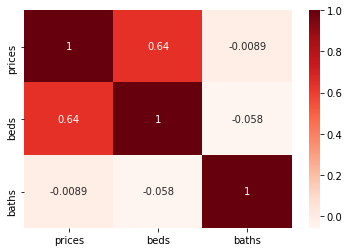

In [40]:
sns.heatmap(zillow_df[['prices','beds','baths']].corr(), annot=True, cmap = 'Reds')
plt.show()


## Model Development - Linear Regressions

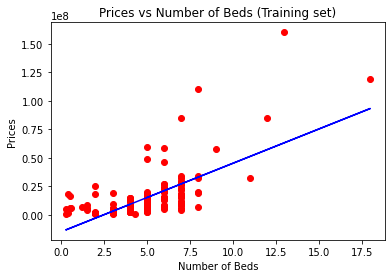

In [41]:
x = zillow_df[['beds']]
y = zillow_df[['prices']]
xTrain, xTest, yTrain, yTest = holdout(x, y, test_size = 0.25, random_state = 0)
linearRegressor = LinearRegression()
linearRegressor.fit(xTrain, yTrain)
yPrediction = linearRegressor.predict(xTest)
plt.scatter(xTrain, yTrain, color = 'red')
plt.plot(xTrain, linearRegressor.predict(xTrain), color = 'blue')
plt.title('Prices vs Number of Beds (Training set)')
plt.xlabel('Number of Beds')
plt.ylabel('Prices')
plt.show()

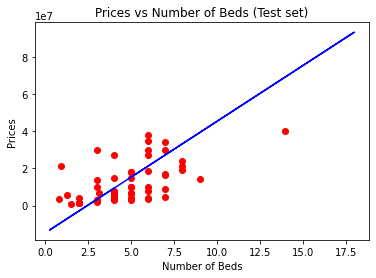

In [42]:
plt.scatter(xTest, yTest, color = 'red')
plt.plot(xTrain, linearRegressor.predict(xTrain), color = 'blue')
plt.title('Prices vs Number of Beds (Test set)')
plt.xlabel('Number of Beds')
plt.ylabel('Prices')
plt.show()

In [55]:
#polynomial regression
pol = PolynomialFeatures (degree = 2)
x_pol = pol.fit_transform(x)
x_train, x_test, y_train, y_test = holdout(x_pol, y, test_size=0.2, random_state=0)
Pol_reg = LinearRegression()
Pol_reg.fit(x_train, y_train)
y_train_pred = Pol_reg.predict(x_train)
y_test_pred = Pol_reg.predict(x_test)
print(Pol_reg.intercept_)
print(Pol_reg.coef_)
print(Pol_reg.score(x_test, y_test))

[1473131.5458037]
[[      0.         -355655.49579622  501198.11796678]]
-0.377502155276497


In [56]:
##Evaluating the performance of the algorithm
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_test_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_test_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))

Mean Absolute Error: 8159924.395739016
Mean Squared Error: 145495572119272.44
Root Mean Squared Error: 12062154.538857162


### Insights
- Most of properties have number of bathrooms between 2 - 8.
- Most of properties are house type, and few of them are condos.
- Most of properties have number of bedrooms between 2 - 8. Only a few of properties have more than 9 bedrooms.
- The greatest average number of house type is new property. The second highest is house type. The third highest is condo.
- The beds and baths features show the strongest correlation in heat map.
- The price has a positive relationship with the number of beds. Price increase as the number of beds increase. However, there are some higher prices with the same number of beds.
